In [1]:
# Library includes
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import random

import requests
import zipfile
from pathlib import Path
import tqdm

# Helper functions

from model_functions import *

from visualize_results import *

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Multi-Model Comparison Variable
models_and_results = []

In [6]:
# Examine 
def walk_through_dir(dir_path):
    print("in walk through dir")
    """Walks through dir_path, returning its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

data_path = Path("../data")
image_path = data_path / "CATANIST V2/"
walk_through_dir(image_path)

in walk through dir
There are 2 directories and 1 images in ../data/CATANIST V2
There are 11 directories and 1 images in ../data/CATANIST V2/test
There are 0 directories and 21 images in ../data/CATANIST V2/test/eight
There are 0 directories and 21 images in ../data/CATANIST V2/test/eleven
There are 0 directories and 21 images in ../data/CATANIST V2/test/nine
There are 0 directories and 21 images in ../data/CATANIST V2/test/three
There are 0 directories and 21 images in ../data/CATANIST V2/test/ten
There are 0 directories and 11 images in ../data/CATANIST V2/test/twelve
There are 0 directories and 11 images in ../data/CATANIST V2/test/two
There are 0 directories and 21 images in ../data/CATANIST V2/test/six
There are 0 directories and 7 images in ../data/CATANIST V2/test/desert
There are 0 directories and 21 images in ../data/CATANIST V2/test/five
There are 0 directories and 21 images in ../data/CATANIST V2/test/four
There are 11 directories and 1 images in ../data/CATANIST V2/train
Th

In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('../data/CATANIST V2/train'), PosixPath('../data/CATANIST V2/test'))

In [65]:
from torchvision.transforms import v2, transforms

train_data_transform = v2.Compose([
    v2.Resize(size=(64, 64)),
    v2.Grayscale(num_output_channels=3),
    v2.RandomAffine(degrees=180,translate=(0.1, 0.1),interpolation=transforms.InterpolationMode.BILINEAR),
    v2.RandomApply([transforms.GaussianBlur(kernel_size=17, sigma=(0.5, 2.0))], p=.6),
    # Turn the image into a torch tensor
    v2.ToTensor(),
])

test_data_transform = v2.Compose([
    v2.Resize(size=(64, 64)),
    v2.Grayscale(num_output_channels=3),
    # v2.RandomApply([transforms.GaussianBlur(kernel_size=17, sigma=(0.5, 2))], p=.8),
    # Turn the image into a torch tensor
    v2.ToTensor(),
])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [66]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_data_transform,
                                 target_transform=None)
class_names = train_data.classes

len(train_data), len(test_data), class_names

(1940,
 186,
 ['desert',
  'eight',
  'eleven',
  'five',
  'four',
  'nine',
  'six',
  'ten',
  'three',
  'twelve',
  'two'])

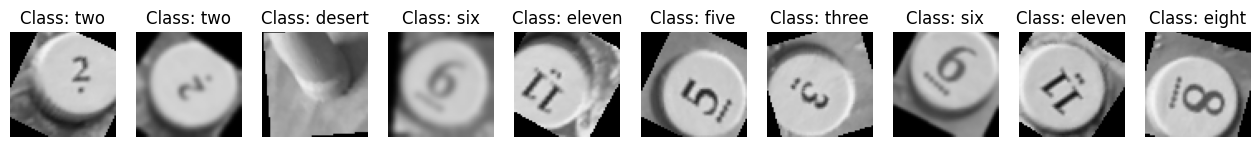

In [67]:
display_random_images(dataset=train_data,
                      classes=class_names,
                      n=10,
                      display_shape=False)

In [68]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16e9ba590>,
 <torch.utils.data.dataloader.DataLoader at 0x16df1a250>)

In [69]:
device = ("cuda" if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available()
        else "cpu"
    )
device

'mps'

# ResNet Model

In [70]:
class BasicBlock(nn.Module):
    def __init__(self, input_shape: int, output_shape:int, stride=1) -> None:
        super(BasicBlock, self).__init__()
        # Conv layer 1
        self.conv1 = nn.Conv2d(input_shape, 
                               output_shape, 
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               bias=False)
        # Batch norm 1
        self.bn1 = nn.BatchNorm2d(output_shape)
        # Activation
        self.relu = nn.ReLU(inplace=True)
        
        # Conv layer 2
        self.conv2 = nn.Conv2d(output_shape, 
                               output_shape,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        # Batch norm 2
        self.bn2 = nn.BatchNorm2d(output_shape)
        
        # Account for differences in stride length if not 1 & num filters
        self.downsample = nn.Sequential()
        if stride != 1 or input_shape != output_shape:
            self.downsample = nn.Sequential(
                nn.Conv2d(input_shape, output_shape,
                          kernel_size=1, stride=stride,
                          bias=False),
                nn.BatchNorm2d(output_shape)
            )
    def forward(self, x):
        identity = x
        logits = self.conv1(x)
        logits = self.bn1(logits)
        logits = self.relu(logits)
        logits = self.conv2(logits)
        logits = self.bn2(logits)
        logits += self.downsample(identity)
        logits = self.relu(logits)
        return logits

In [71]:
class ResNet(nn.Module):
    def __init__(self, input_shape, block, layers, class_cnt):
        super(ResNet, self).__init__()
        self.num_classes = class_cnt
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=input_shape, 
                               out_channels=64, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # Create 3 'blocks'
        self.block1 = self.make_layer(block, 64, layers[0], stride=1)
        self.block2 = self.make_layer(block, 128, layers[1], stride=2)
        self.block3 = self.make_layer(block, 256, layers[2], stride=2)
        # Average pooling
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layer
        self.fc = nn.Linear(256, class_cnt)
    def make_layer(self, block, output_shape, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, output_shape, stride))
        self.in_channels = output_shape
        for _ in range(1, blocks):
            layers.append(block(output_shape, output_shape, stride=1))
        return nn.Sequential(*layers)
    def forward(self, x):
        logits = self.conv1(x)
        # print(f"x shape after conv block 1: {x.shape}")
        logits = self.bn1(logits)
        # print(f"x shape after batch norm 1: {x.shape}")
        logits = self.relu(logits)
        logits = self.block1(logits)
        # print(f"x shape after res block 1: {x.shape}")
        logits = self.block2(logits)
        # print(f"x shape after res block 2: {x.shape}")
        logits = self.block3(logits)
        # print(f"x shape after res block 3: {x.shape}")
        logits = self.avg_pool(logits)
        logits = logits.view(logits.size(0), -1)
        logits = self.fc(logits)
        return logits

In [72]:
model = ResNet(input_shape=3, 
               block=BasicBlock,
               layers=[2, 2, 2],
               class_cnt=len(class_names)).to(device)

## Test Image

In [73]:
# Get a single image batch
image_batch, label_batch = next(iter(test_dataloader))
image_batch.shape, label_batch.shape
model(image_batch.to(device))

tensor([[-0.0526,  0.0906,  0.1590, -0.1714,  0.4304, -0.6725,  0.5683, -0.2178,
          0.3974,  0.1504, -0.0799],
        [-0.0960,  0.0422,  0.1505, -0.1450,  0.4286, -0.6257,  0.5628, -0.2520,
          0.3535,  0.1803, -0.1529],
        [-0.0124,  0.1192,  0.1912, -0.1161,  0.4376, -0.6565,  0.5209, -0.2424,
          0.3313,  0.2211, -0.0342],
        [-0.0278,  0.0616,  0.1727, -0.2172,  0.4702, -0.7135,  0.5164, -0.2151,
          0.3095,  0.1412, -0.0537],
        [-0.1967,  0.1074,  0.2391, -0.0764,  0.4069, -0.6371,  0.5224, -0.3085,
          0.3450,  0.2057, -0.2246],
        [-0.1707,  0.1215,  0.2692, -0.0052,  0.4767, -0.5966,  0.5600, -0.2756,
          0.3547,  0.1650, -0.2771],
        [-0.1572,  0.0669,  0.4649, -0.8425,  0.8283, -0.9346,  0.8564, -0.2916,
          0.7281,  0.0450,  0.0668],
        [ 0.0152,  0.0398,  0.3802, -0.2877,  0.5357, -0.7467,  0.6978, -0.2434,
          0.4075,  0.2627,  0.0320],
        [-0.1181,  0.0796,  0.3445, -0.7035,  0.7980, -0

In [74]:
# Model variables
INPUT_SHAPE = 3
OUTPUT_SHAPE = len(class_names)
# Hyperparameters (Batch size is in cell 10)
EPOCHS = 25
LEARNING_RATE = 0.001
LOSS_FN = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

hyperparameters = {"Model Name": "ResNet","Epochs":EPOCHS, "Batch Size": BATCH_SIZE, "Learning Rate":LEARNING_RATE, "Loss Function": LOSS_FN, "Optimizer": optimizer}
hyperparameters

{'Model Name': 'ResNet',
 'Epochs': 25,
 'Batch Size': 32,
 'Learning Rate': 0.001,
 'Loss Function': CrossEntropyLoss(),
 'Optimizer': torch.optim.adam.Adam}

In [75]:
### Train ResNet
model_resnet = ResNet(input_shape=INPUT_SHAPE, 
                    block=BasicBlock,
                    layers=[2, 2, 2],
                    class_cnt=OUTPUT_SHAPE).to(device)

resnet_optimizer = optimizer(model_resnet.parameters(), lr=LEARNING_RATE)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train simple model
model_resnet_results = train(model=model_resnet,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            optimizer=resnet_optimizer,
                            loss_fn=LOSS_FN,
                            epochs=EPOCHS,
                            device=device)

# End the timer
end_time = timer()
print(f"ResNet training time: {end_time-start_time:.3f} seconds")

# Record results into a list of tuples where each tuple has the hyperparameter dictionary as well as the results
models_and_results.append([hyperparameters, model_resnet_results])

  4%|▍         | 1/25 [00:09<03:37,  9.07s/it]

Epoch: 1 | train_loss: 1.6739 | train_acc: 0.3870 | test_loss: 7.5615 | test_acc: 0.1426


  8%|▊         | 2/25 [00:17<03:21,  8.76s/it]

Epoch: 2 | train_loss: 1.0033 | train_acc: 0.6748 | test_loss: 14.3788 | test_acc: 0.1354


 12%|█▏        | 3/25 [00:26<03:09,  8.62s/it]

Epoch: 3 | train_loss: 0.6696 | train_acc: 0.7926 | test_loss: 3.5410 | test_acc: 0.3177


 16%|█▌        | 4/25 [00:34<02:57,  8.45s/it]

Epoch: 4 | train_loss: 0.4127 | train_acc: 0.8876 | test_loss: 3.4074 | test_acc: 0.3958


 20%|██        | 5/25 [00:42<02:47,  8.38s/it]

Epoch: 5 | train_loss: 0.3284 | train_acc: 0.9131 | test_loss: 2.9030 | test_acc: 0.2760


 24%|██▍       | 6/25 [00:50<02:38,  8.34s/it]

Epoch: 6 | train_loss: 0.2259 | train_acc: 0.9474 | test_loss: 8.5008 | test_acc: 0.1771


 28%|██▊       | 7/25 [00:58<02:29,  8.29s/it]

Epoch: 7 | train_loss: 0.1715 | train_acc: 0.9517 | test_loss: 2.7832 | test_acc: 0.3750


 32%|███▏      | 8/25 [01:07<02:20,  8.28s/it]

Epoch: 8 | train_loss: 0.1252 | train_acc: 0.9723 | test_loss: 2.0942 | test_acc: 0.5312


 36%|███▌      | 9/25 [01:15<02:12,  8.27s/it]

Epoch: 9 | train_loss: 0.0907 | train_acc: 0.9756 | test_loss: 7.4743 | test_acc: 0.4010


 40%|████      | 10/25 [01:23<02:04,  8.27s/it]

Epoch: 10 | train_loss: 0.0620 | train_acc: 0.9923 | test_loss: 7.1769 | test_acc: 0.2656


 44%|████▍     | 11/25 [01:32<01:55,  8.28s/it]

Epoch: 11 | train_loss: 0.0982 | train_acc: 0.9775 | test_loss: 0.4427 | test_acc: 0.8782


 48%|████▊     | 12/25 [01:40<01:47,  8.26s/it]

Epoch: 12 | train_loss: 0.0716 | train_acc: 0.9851 | test_loss: 1.1768 | test_acc: 0.5905


 52%|█████▏    | 13/25 [01:48<01:39,  8.25s/it]

Epoch: 13 | train_loss: 0.0570 | train_acc: 0.9862 | test_loss: 2.0832 | test_acc: 0.5397


 56%|█████▌    | 14/25 [01:56<01:30,  8.26s/it]

Epoch: 14 | train_loss: 0.0369 | train_acc: 0.9927 | test_loss: 4.7838 | test_acc: 0.3177


 60%|██████    | 15/25 [02:05<01:22,  8.27s/it]

Epoch: 15 | train_loss: 0.0794 | train_acc: 0.9810 | test_loss: 4.2552 | test_acc: 0.3229


 64%|██████▍   | 16/25 [02:13<01:14,  8.27s/it]

Epoch: 16 | train_loss: 0.0529 | train_acc: 0.9877 | test_loss: 0.8911 | test_acc: 0.8077


 68%|██████▊   | 17/25 [02:21<01:06,  8.27s/it]

Epoch: 17 | train_loss: 0.0344 | train_acc: 0.9923 | test_loss: 0.1810 | test_acc: 0.9635


 72%|███████▏  | 18/25 [02:29<00:57,  8.27s/it]

Epoch: 18 | train_loss: 0.0829 | train_acc: 0.9769 | test_loss: 3.8143 | test_acc: 0.4271


 76%|███████▌  | 19/25 [08:53<12:06, 121.04s/it]

Epoch: 19 | train_loss: 0.0736 | train_acc: 0.9810 | test_loss: 10.7828 | test_acc: 0.2760


 80%|████████  | 20/25 [13:13<13:34, 162.88s/it]

Epoch: 20 | train_loss: 0.0341 | train_acc: 0.9939 | test_loss: 0.2864 | test_acc: 0.9235


 84%|████████▍ | 21/25 [13:40<08:08, 122.01s/it]

Epoch: 21 | train_loss: 0.0116 | train_acc: 1.0000 | test_loss: 0.0052 | test_acc: 1.0000


 88%|████████▊ | 22/25 [13:49<04:24, 88.04s/it] 

Epoch: 22 | train_loss: 0.0172 | train_acc: 0.9964 | test_loss: 2.3467 | test_acc: 0.5036


 92%|█████████▏| 23/25 [13:57<02:08, 64.13s/it]

Epoch: 23 | train_loss: 0.0066 | train_acc: 1.0000 | test_loss: 0.0190 | test_acc: 0.9936


 96%|█████████▌| 24/25 [14:06<00:47, 47.40s/it]

Epoch: 24 | train_loss: 0.0320 | train_acc: 0.9923 | test_loss: 0.3370 | test_acc: 0.8846


100%|██████████| 25/25 [14:14<00:00, 34.19s/it]

Epoch: 25 | train_loss: 0.0342 | train_acc: 0.9913 | test_loss: 0.0598 | test_acc: 0.9896
ResNet training time: 209.861 seconds


### Pre new data:
Epoch: 25 | train_loss: 0.0145 | train_acc: 0.9991 | test_loss: 0.2460 | test_acc: 0.9167
ResNet training time: 114.415 seconds
### Post new data
Epoch: 25 | train_loss: 0.0342 | train_acc: 0.9913 | test_loss: 0.0598 | test_acc: 0.9896
### Post new data with NO GRAYSCALE
Epoch: 25 | train_loss: 0.0519 | train_acc: 0.9877 | test_loss: 12.6069 | test_acc: 0.1114
HORRIBLE!!!!

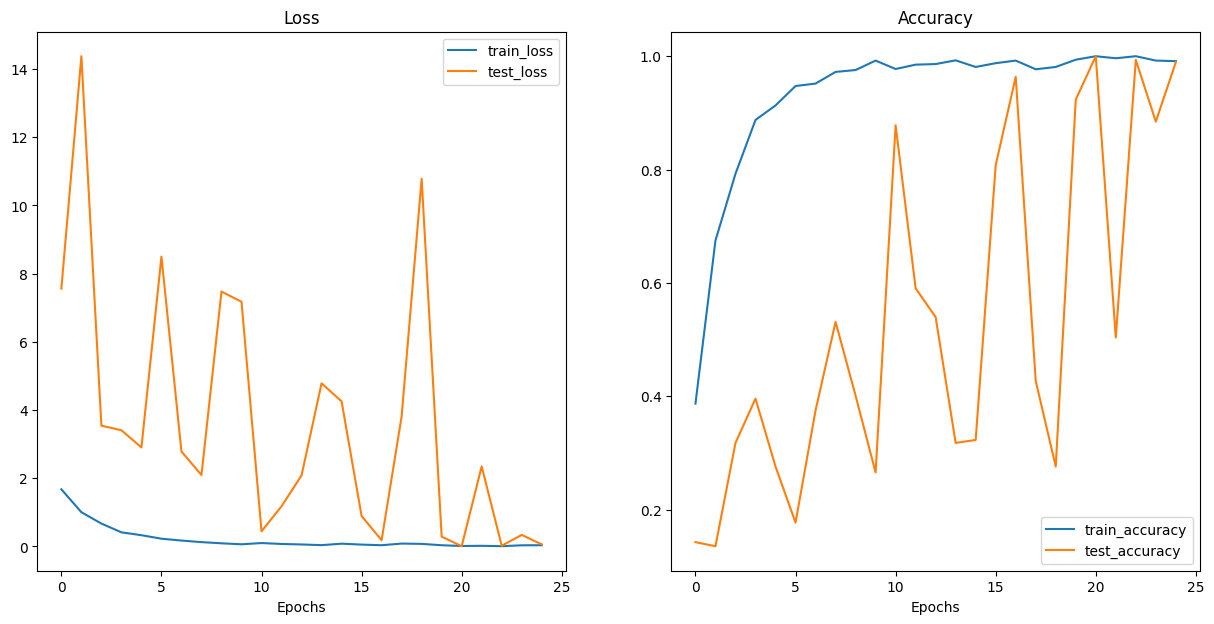

In [83]:
plot_loss_curves(model_resnet_results)

## Test on a custom image

In [96]:
custom_image_path = "../images/eval numbers/005.jpg"

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image /= 255

custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.Grayscale(num_output_channels=3)
])

custom_image_transformed = custom_image_transform(custom_image[:3, :, :])

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 60, 60])
New shape: torch.Size([3, 64, 64])


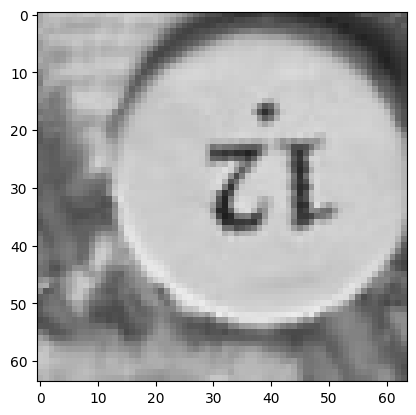

In [97]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [98]:
class_names

['desert',
 'eight',
 'eleven',
 'five',
 'four',
 'nine',
 'six',
 'ten',
 'three',
 'twelve',
 'two']

In [99]:
model_resnet.eval()
with torch.inference_mode():
    custom_image_pred = model_resnet(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction class: {class_names[custom_image_pred_label], custom_image_pred_label}")

Prediction class: ('twelve', tensor([9], device='mps:0'))


## Save the model

In [100]:
from pathlib import Path 

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create the model save path
MODEL_NAME = "catanistv2_3.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model's state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_resnet.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/catanistv2_3.pth


In [101]:
sorted(['desert',
 'eight',
 'eleven',
 'five',
 'four',
 'nine',
 'six',
 'ten',
 'three',
 'twelve',
 'two'])

['desert',
 'eight',
 'eleven',
 'five',
 'four',
 'nine',
 'six',
 'ten',
 'three',
 'twelve',
 'two']